In [2]:
import pandas as pd
import numpy as np

import time
import datetime

from tqdm import tqdm_notebook as tqdm

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns

# matplotlib 폰트설정
plt.rc('font', family='NanumGothic') # For Windows

from glob import glob
from keras.preprocessing.image import load_img

Using TensorFlow backend.


In [3]:
## 중앙으로 배치
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# (1). mahotas

## 1.1 분류 모델: classification

### 1.1.1 image load

* train

In [91]:
bag_images = glob('./train/bag/*.jpg')
dress_images = glob('./train/dress/*.jpg')
print('train_가방:', len(bag_images), '\ntrain_드레스:', len(dress_images))

train_가방: 17224 
train_드레스: 17208


In [92]:
bag = pd.DataFrame(bag_images, columns = ['name'])
bag['label'] = 'bag'

dress = pd.DataFrame(dress_images, columns = ['name'])
dress['label'] = 'dress'

## 병합
train_img = pd.concat([bag, dress], axis = 0).reset_index(drop = True)
train_img.tail()

,name,label
34427,./train/dress\9995_A.P.C..jpg,dress
34428,./train/dress\9996_Mes Demoiselles.jpg,dress
34429,./train/dress\9997_Alice McCall.jpg,dress
34430,./train/dress\9998_Carolina Herrera.jpg,dress
34431,./train/dress\9999_MSGM.jpg,dress


* validation

In [16]:
val_bag = glob('./data/validation/bag/*.jpg')
val_dress = glob('./data/validation/dress/*.jpg')
print('validation_가방:', len(val_bag), '\nvalidation_드레스:', len(val_dress))

validation_가방: 662 
validation_드레스: 500


In [18]:
val_bag = pd.DataFrame(val_bag, columns = ['name'])
val_bag['label'] = 'bag'

val_dress = pd.DataFrame(val_dress, columns = ['name'])
val_dress['label'] = 'dress'

## 병합
val_img = pd.concat([val_bag, val_dress], axis = 0).reset_index(drop = True)
val_img.tail()

,name,label
1157,./data/validation/dress\96_Isabel Marant.jpg,dress
1158,./data/validation/dress\97_Khaite.jpg,dress
1159,./data/validation/dress\98_Tom Ford.jpg,dress
1160,./data/validation/dress\99_Chloé.jpg,dress
1161,./data/validation/dress\9_ROTATE.jpg,dress


### 1.1.2 feature 추출

In [12]:
import mahotas as mh

* train

In [4]:
features = []
labels = []
for num, im in tqdm(enumerate(train_img['name'])):
    labels.append(train_img['label'][num])
    im = mh.imread(im)
    im = mh.colors.rgb2gray(im, dtype=np.uint8)
    features.append(mh.features.haralick(im).ravel())
    
features = np.array(features)
labels = np.array(labels)

In [5]:
## 저장
np.save('mahotas_features.npy', features)
np.save('mahotas_labels.npy', labels)

* validation

In [21]:
features = []
labels = []
for num, im in tqdm(enumerate(val_img['name'])):
    labels.append(val_img['label'][num])
    im = mh.imread(im)
    im = mh.colors.rgb2gray(im, dtype=np.uint8)
    features.append(mh.features.haralick(im).ravel())
    
features = np.array(features)
labels = np.array(labels)

In [22]:
## 저장
np.save('mahotas_features_val.npy', features)
np.save('mahotas_labels_val.npy', labels)

* 실행: 저장한 파일 불러오기

In [3]:
features2 = np.load('mahotas_features.npy')
labels2 = np.load('mahotas_labels.npy')

In [23]:
val_features2 = np.load('mahotas_features_val.npy')
val_labels2 = np.load('mahotas_labels_val.npy')

In [10]:
features2[0]

array([ 4.62652305e-01,  1.99550201e+02,  9.87859653e-01,  8.21847171e+03,
        7.78861513e-01,  4.14967408e+02,  3.26743366e+04,  3.27155922e+00,
        4.34444474e+00,  2.13140652e-03,  2.06181921e+00, -5.02482393e-01,
        9.72534377e-01,  4.56079626e-01,  4.16818887e+02,  9.74687307e-01,
        8.23339656e+03,  7.48803724e-01,  4.14729231e+02,  3.25167673e+04,
        3.31093630e+00,  4.54235518e+00,  1.98865664e-03,  2.40599243e+00,
       -4.37454142e-01,  9.59895584e-01,  4.65120874e-01,  2.86700033e+02,
        9.82547004e-01,  8.21349045e+03,  7.65069192e-01,  4.15046800e+02,
        3.25672618e+04,  3.25592541e+00,  4.42999698e+00,  2.09302755e-03,
        2.24104375e+00, -4.71952154e-01,  9.67058866e-01,  4.56224290e-01,
        4.29468839e+02,  9.73919097e-01,  8.23339656e+03,  7.48945879e-01,
        4.14729231e+02,  3.25041174e+04,  3.31175291e+00,  4.54190462e+00,
        1.99231854e-03,  2.40647915e+00, -4.37609133e-01,  9.59932461e-01])

In [9]:
features2[0].shape

(52,)

### 1.1.3 classification

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [11]:
clf = Pipeline([('preproc', StandardScaler()), ('classifier', LogisticRegression())])
clf

Pipeline(memory=None,
     steps=[('preproc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classifier', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

* 교차검증: k-fold(5)

In [9]:
from sklearn.model_selection import KFold, cross_val_score

kfold = KFold(n_splits=5, random_state=0, shuffle=True)
scores_fold = cross_val_score(clf, features2, labels2, cv=kfold) # model, train, target, cross validation
print('mean score_kfold \n{:.2f}'.format(scores_fold.mean()))

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs

mean score_kfold 
0.97


* validation

In [12]:
clf.fit(features2, labels2)

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
     steps=[('preproc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classifier', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [25]:
pred = clf.predict(val_features2)
print('mahotas package Accuracy:', accuracy_score(val_labels2, pred))

mahotas package Accuracy: 0.9664371772805508


In [29]:
cf = confusion_matrix(val_labels2, pred)
print('mahotas package Accuracy:', accuracy_score(val_labels2, pred))
print(cf)

mahotas package Accuracy: 0.9664371772805508
[[646  16]
 [ 23 477]]


## 1.2 가방: 유사 이미지 찾기 - 거리 기반

In [13]:
import mahotas as mh

### 1.2.1 image name

In [46]:
## train image
train_images = glob('./train/bag/*.jpg')
print('train image length:', len(train_images))

train image length: 17224


In [53]:
## test image name 
## 유사한 이미지를 찾고자 하는 이미지를 test폴더에 넣는다
test_images = glob('./data/test/*.jpg')
test_images = np.array(test_images)
print('test image length:', len(test_images))

test image length: 14


In [51]:
## train + input(test)
train_images.extend(test_images)
bag_images = train_images
print('after input:', len(bag_images))

after input: 17246


In [52]:
## input image index
f = lambda x : 'test' in x
input_tf = list(map(f, bag_images))
input_ind = [i for i, x in enumerate(input_tf) if x]
input_ind

[17232,
 17233,
 17234,
 17235,
 17236,
 17237,
 17238,
 17239,
 17240,
 17241,
 17242,
 17243,
 17244,
 17245]

### 1.2.2 feature 추출

* train

In [99]:
## 실행X
train_feature = []
for im in tqdm(train_images):
    im = mh.imread(im)
    im = mh.colors.rgb2gray(im, dtype = np.uint8)
    train_feature.append(mh.features.haralick(im).ravel())
    
train_feature = np.array(bag_feature)
print('bag image total length:', len(train_feature))


bag image total length: 17238


In [38]:
## 저장 <- 실행X
np.save('mahotas_features_train_bag',train_feature)

In [104]:
## 실행O
train_feature = np.load('mahotas_features_train_bag.npy')

* test

In [54]:
## 실행O
test_feature = []
for im in tqdm(test_images):
    im = mh.imread(im)
    im = mh.colors.rgb2gray(im, dtype = np.uint8)
    test_feature.append(mh.features.haralick(im).ravel())
    
test_feature = np.array(test_feature)
print('test image total length:', len(test_feature))


test image total length: 14


In [56]:
## 저장 <- 실행O
np.save('mahotas_features_test_bag',test_feature)

In [105]:
## 실행O
test_feature = np.load('mahotas_features_test_bag.npy')

* train + test 병합

In [106]:
bag_feature = np.concatenate((train_feature, test_feature))
bag_feature.shape

(17246, 52)

In [107]:
## 저장
np.save('mahotas_feature_train_test_ver',bag_feature)

In [109]:
## 실행
bag_feature = np.load('mahotas_feature_train_test_ver.npy')
bag_feature.shape

(17246, 52)

### 1.2.3 유사한 이미지 찾는 모델 - 거리기반

* 필요한 data load

In [ ]:
# image name
train_images = glob('./train/bag/*.jpg')
test_images = glob('./data/test/*.jpg')
train_images.extend(test_images)
bag_images = train_images

# feature
bag_feature = np.load('mahotas_feature_train_test_ver.npy')

In [85]:
start = time.time()

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
bag_features = sc.fit_transform(bag_feature)

from scipy.spatial import distance
dists = distance.squareform(distance.pdist(bag_features))

sec = time.time()-start
times = str(datetime.timedelta(seconds = sec)).split(".")
times = times[0]
print(times.split(':')[1] + 'min: ' + times.split(':')[2] + 'sec')

00min: 21sec


In [86]:
## 거리 기반 모델 -> m번째로 유사한 이미지 추출하는 함수
def selectImage(n, m, dists, images):
    global image_position
    image_position = dists[n].argsort()[m]
    image = mh.imread(bag_images[image_position])
    return image

## plot print
def plotImages(n):
    plt.figure(figsize=(5,3),)
    plt.imshow(mh.imread(bag_images[n]))
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(bag_images[n].split('_')[-1].split('.jpg')[0], fontsize = 15)
    plt.title('Original Image', fontsize = 20)
    plt.show()
    
    m = 1
    plt.figure(figsize=(20,8))
    for i in range(1,11):
        plt.subplot(2,5,i)
        plt.imshow(selectImage(n, m, dists, bag_images))
        plt.xticks([])
        plt.yticks([])
        plt.xlabel(bag_images[image_position].split('_')[-1].split('.jpg')[0], fontsize = 13)
        m += 1
    plt.show()

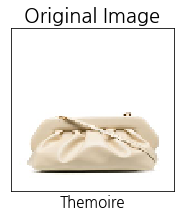

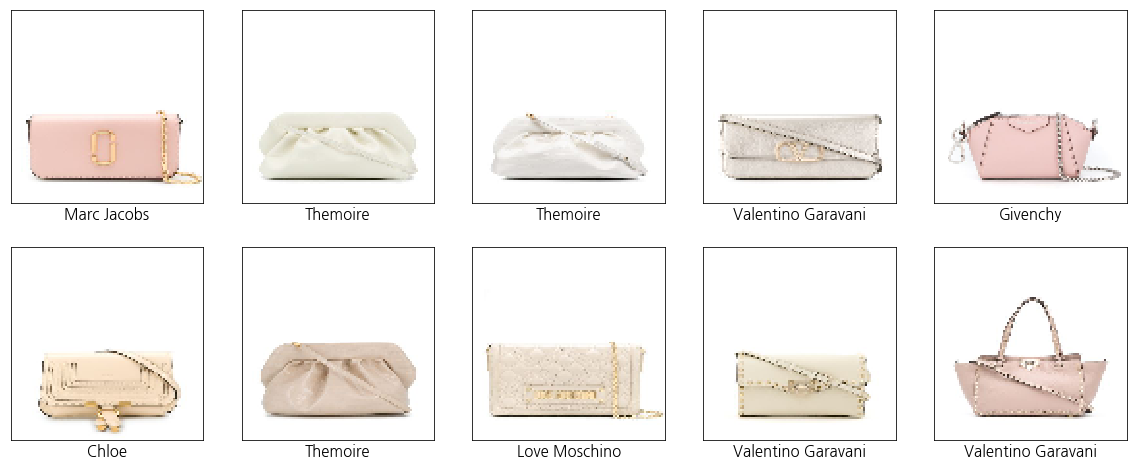

In [127]:
plotImages(input_ind[0])

# (2). PCA -> KNN

## 2.1 분류 모델(PCA 전과 후 비교)

### 2.1.1 data load 및 전처리

* data load

In [30]:
from keras.preprocessing.image import ImageDataGenerator

In [31]:
train = ImageDataGenerator(rescale=1.0/255).flow_from_directory(
    './data/train',     # 이미지 디렉토리
    target_size=(100, 100),
    batch_size=1,
    color_mode='rgb',       # 컬러는 rgb, 흑백은 grayscale. 생략하면 컬러로 처리한다
    class_mode='binary', # 드레스 vs. 가방으로 binary 분류
    shuffle = False 
)   

Found 10020 images belonging to 2 classes.


In [32]:
valid = ImageDataGenerator(rescale=1.0/255).flow_from_directory(
    './data/validation',
    target_size=(100, 100),
    batch_size=1,
    color_mode = 'rgb',
    class_mode='binary',
    shuffle=False)

Found 1162 images belonging to 2 classes.


* 전처리

In [33]:
## train 전처리
train_x = []
for i in tqdm(range(0, len(train))):
    train_x.append(train[i][0].flatten())
len(train_x)

train_y = train.classes

In [34]:
## validation 전처리
valid_x = []
for i in tqdm(range(0, len(valid))):
    valid_x.append(valid[i][0].flatten())
len(valid_x)

valid_y = valid.classes

### 2.1.2 Logistic Regression

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [28]:
def Logisticregression(x_train, x_valid):
    start = time.time()
    
    clf = LogisticRegression(random_state=0)
    clf.fit(x_train, train_y)
    sec = time.time() - start
    times = str(datetime.timedelta(seconds = sec)).split(".")
    times = times[0]
    print(times.split(':')[1] + 'min: ' + times.split(':')[2] + 'sec')

    pred = clf.predict(x_valid)
    print('Logistic Regression Accuracy:', accuracy_score(valid_y, pred))
    
    cf = confusion_matrix(valid_y, pred)
    print(cf)

* Before PCA

In [30]:
Logisticregression(train_x, valid_x)

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


02min: 34sec
Logistic Regression Accuracy: 0.9879518072289156
[[650  12]
 [  2 498]]


* After PCA

In [35]:
from sklearn.decomposition import PCA

In [36]:
## PCA
start = time.time()

pca_lo = PCA(n_components = 30, random_state=0)
train_pca = pca_lo.fit_transform(train_x)
valid_pca = pca_lo.fit_transform(valid_x)

sec = time.time() - start
times = str(datetime.timedelta(seconds = sec)).split(".")
times = times[0]
print(times.split(':')[1] + 'min: ' + times.split(':')[2] + 'sec')

00min: 37sec


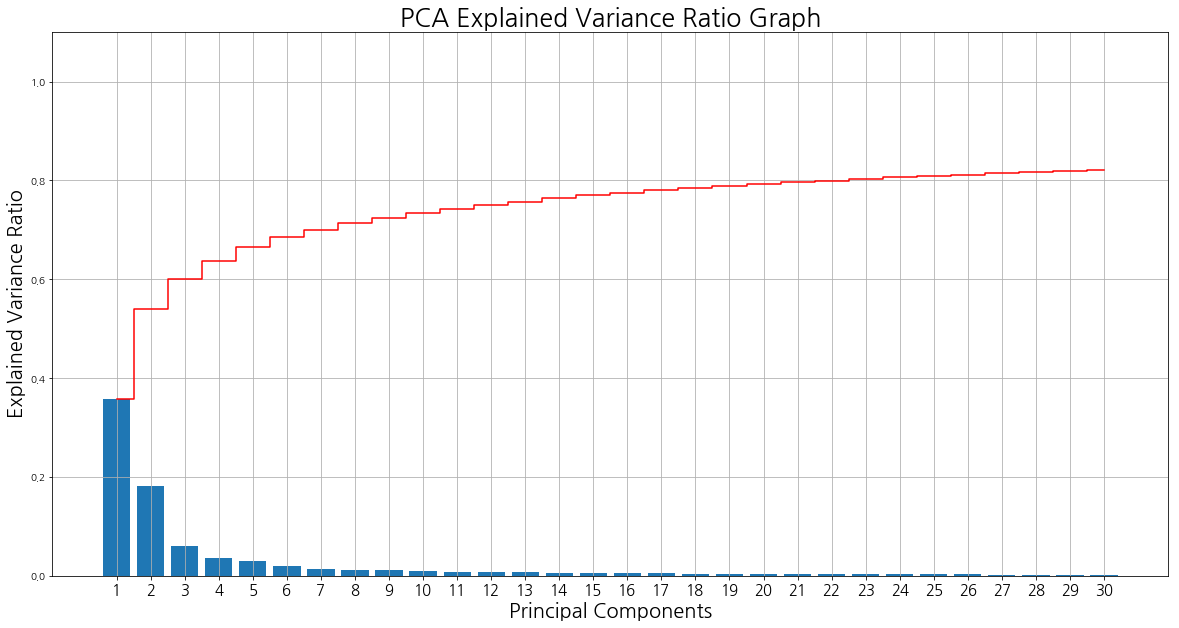

In [37]:
explained_variance_ratio = pca_lo.explained_variance_ratio_

def explained_variance_ratio_plot(explained_variance_ratio):
    x_axis = range(1, len(explained_variance_ratio)+1)
    
    plt.figure(figsize=(20,10))
    plt.bar(x_axis, explained_variance_ratio,
            align = 'center', label = 'Individual Explained Variance Ratio')
    plt.step(x_axis, np.cumsum(explained_variance_ratio),
             where = 'mid', color='red', label='Cumulative Explained Variance Ratio')
    plt.ylim(0, 1.1)
    plt.xticks(x_axis, fontsize = 15)
    plt.title('PCA Explained Variance Ratio Graph', fontsize = 25)
    plt.xlabel('Principal Components', fontsize = 20)
    plt.ylabel('Explained Variance Ratio', fontsize = 20)
    plt.grid()
    plt.show()

explained_variance_ratio_plot(explained_variance_ratio)

In [40]:
np.cumsum(pca_lo.explained_variance_ratio_)[-1]

0.8211876744944151

In [29]:
Logisticregression(train_pca, valid_pca)

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


00min: 00sec
Logistic Regression Accuracy: 0.9440619621342513
[[652  10]
 [ 55 445]]


### 2.1.3 RandomForest

In [39]:
from sklearn.ensemble import RandomForestClassifier

In [85]:
def Randomforest(x_train, x_valid):
    start = time.time()
    
    rf = RandomForestClassifier(random_state=0, 
                                max_depth = 10, 
                                n_estimators=100,
                               n_jobs=-1)
    rf.fit(x_train, train_y)
    sec = time.time() - start
    times = str(datetime.timedelta(seconds = sec)).split(".")
    times = times[0]
    print(times.split(':')[1] + 'min: ' + times.split(':')[2] + 'sec')

    pred = rf.predict(x_valid)
    print('Logistic Regression Accuracy:', accuracy_score(valid_y, pred))
    
    cf = confusion_matrix(valid_y, pred)
    print(cf)

* Before PCA

In [86]:
Randomforest(train_x, valid_x)

00min: 11sec
Logistic Regression Accuracy: 0.9913941480206541
[[652  10]
 [  0 500]]


* After PCA

In [87]:
Randomforest(train_pca, valid_pca)

00min: 00sec
Logistic Regression Accuracy: 0.9466437177280551
[[639  23]
 [ 39 461]]


### 2.1.4 XGBoost

In [54]:
import xgboost as xgb ## XGBoost 불러오기

In [70]:
def xgboost(x_train, x_valid):
    start = time.time()
    
    #xgb = XGBClassifier(random_state=0)
    
    dtrain = xgb.DMatrix(data=np.asarray(x_train), label = np.asarray(train_y))
    dvalid = xgb.DMatrix(data=np.asarray(x_valid), label=np.asarray(valid_y))
    
    params = {'max_depth':3,
              'eta':0.1,
             'objective':'binary:logistic',
             'eval_metric':'logloss',
             'early_stoppings':30}
    num_rounds=50
    
    w_list = [(dtrain,'train'),(dvalid,'valid')]
    xgb_ml = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_rounds,
                       early_stopping_rounds=30, evals=w_list)
    
    sec = time.time() - start
    times = str(datetime.timedelta(seconds = sec)).split(".")
    times = times[0]
    print(times.split(':')[1] + 'min: ' + times.split(':')[2] + 'sec')
    
    pred_probs = xgb_ml.predict(dvalid)
    pred=[1 if x > 0.5 else 0 for x in pred_probs]
    print('Logistic Regression Accuracy:', accuracy_score(valid_y, pred))
    
    cf = confusion_matrix(valid_y, pred)
    print(cf)

In [71]:
xgboost(train_x, valid_x)

[16:47:11] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { early_stoppings } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-logloss:0.60167	valid-logloss:0.60329
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 30 rounds.
[1]	train-logloss:0.52634	valid-logloss:0.52951
[2]	train-logloss:0.46339	valid-logloss:0.46877
[3]	train-logloss:0.41012	valid-logloss:0.41597
[4]	train-logloss:0.36450	valid-logloss:0.37096
[5]	train-logloss:0.32511	valid-logloss:0.33259
[6]	train-logloss:0.29074	valid-logloss:0.29943
[7]	train-logloss:0.26072	valid-logloss:0.27051
[8]	train-logloss:0.23424	valid-logloss:0.24517
[9]	train-logloss:0.2110

In [72]:
xgboost(train_pca, valid_pca)

[16:50:38] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { early_stoppings } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-logloss:0.61499	valid-logloss:0.62001
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 30 rounds.
[1]	train-logloss:0.55085	valid-logloss:0.55974
[2]	train-logloss:0.49618	valid-logloss:0.51136
[3]	train-logloss:0.45041	valid-logloss:0.46978
[4]	train-logloss:0.41099	valid-logloss:0.43328
[5]	train-logloss:0.37709	valid-logloss:0.40188
[6]	train-logloss:0.34575	valid-logloss:0.37306
[7]	train-logloss:0.31847	valid-logloss:0.34826
[8]	train-logloss:0.29501	valid-logloss:0.32781
[9]	train-logloss:0.2735

## 2.2 이미지 유사도를 위한 PCA

### 2.2.1 data load

* image name

In [59]:
## train
train_images = glob('./train/bag/*.jpg')
train_images[0]

'./train/bag\\0_Saint Laurent.jpg'

In [73]:
## test(input)
test_images = glob('./data/test/*.jpg')

In [63]:
## train + test
train_images.extend(test_images)
bag_image = train_images

* image vector

In [96]:
## train
img_list = []
for bag_name in tqdm(train_images):
    img = load_img(bag_name, target_size = (100,100))
    img_array = np.array(img)/255
    img_list.append(img_array)

KeyboardInterrupt: 

In [12]:
img_array = np.array(img_list)
np.save('bag_img_vector_train_bag.npy', img_array) #저장

In [74]:
## test(input)
test_img_list = []
for bag_name in tqdm(test_images):
    img = load_img(bag_name, target_size = (100,100))
    img_array = np.array(img)/255
    test_img_list.append(img_array)

In [76]:
test_img_array = np.array(test_img_list)
np.save('bag_img_vector_test_bag.npy', test_img_array) #저장

In [69]:
## input image index
f = lambda x : 'test' in x
input_tf = list(map(f, bag_images))
input_ind = [i for i, x in enumerate(input_tf) if x]
input_ind

[17232,
 17233,
 17234,
 17235,
 17236,
 17237,
 17238,
 17239,
 17240,
 17241,
 17242,
 17243,
 17244,
 17245]

* 데이터 불러오기

In [78]:
## train
vec = np.load('bag_img_vector_train_bag.npy')
print(vec[0].shape)
print('train length:', vec.shape[0])

(100, 100, 3)
train length: 17232


In [79]:
## test(input image)
test_vec = np.load('bag_img_vector_test_bag.npy')
print(test_vec[0].shape)
print('test length:', test_vec.shape[0])

(100, 100, 3)
test length: 14


In [80]:
## train + test
vec = np.concatenate((vec, test_vec))

print(vec[0].shape)
print('train + test length:', vec.shape[0])

(100, 100, 3)
train + test length: 17246


In [85]:
## 저장
np.save('bag_img_vector_train_test_ver.npy', vec)

In [87]:
## 실행
vec = np.load('bag_img_vector_train_test_ver.npy')

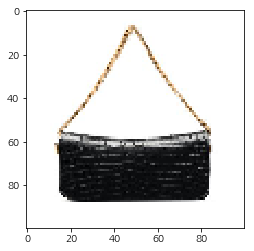

In [14]:
plt.imshow(vec[0])

In [83]:
vec_list = []
for i in tqdm(vec):
    vec_list.append(i.flatten())
len(vec_list)

17246

### 2.2.2 PCA

In [84]:
from sklearn.decomposition import PCA
start = time.time()

pca = PCA(n_components = 30, random_state=0)
principalComponents = pca.fit_transform(vec_list)

sec = time.time() - start
times = str(datetime.timedelta(seconds = sec)).split(".")
times = times[0]
print(times.split(':')[1] + 'min: ' + times.split(':')[2] + 'sec')

01min: 44sec


In [88]:
principalComponents[0]

array([  5.65627403, -24.62558926,  -2.90934934,  16.70477194,
         5.18400963,  -4.06487586,  -1.04759469, -12.12553618,
        -3.0070028 ,   2.89738924,   3.17786403,   0.51875948,
        -2.23899881,  -1.00523733,  -1.21024303,   1.64930401,
         2.88538454,  -3.77162219,  -3.03505697,  -0.76596215,
         1.30743096,   2.68367907,   1.76200172,  -0.59509934,
         2.53918726,  -0.84529663,  -0.81002244,   1.80920649,
         0.40692821,   1.92485545])

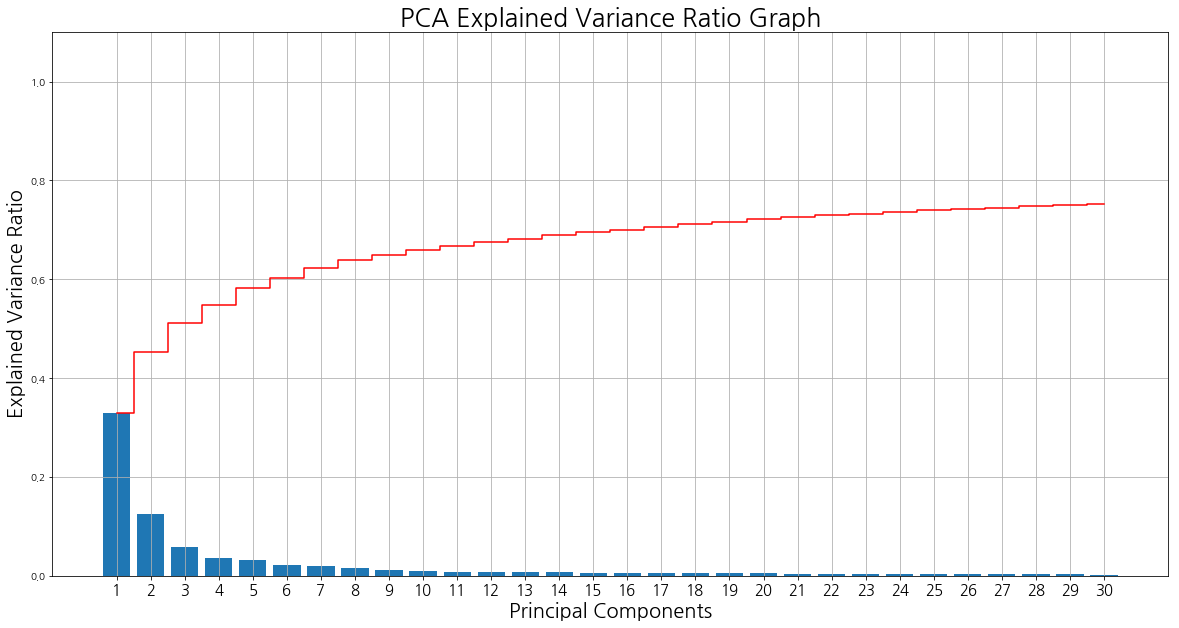

In [44]:
import matplotlib.pyplot as plt 

explained_variance_ratio = pca.explained_variance_ratio_

def explained_variance_ratio_plot(explained_variance_ratio):
    x_axis = range(1, len(explained_variance_ratio)+1)
    
    plt.figure(figsize=(20,10))
    plt.bar(x_axis, explained_variance_ratio,
            align = 'center', label = 'Individual Explained Variance Ratio')
    plt.step(x_axis, np.cumsum(explained_variance_ratio),
             where = 'mid', color='red', label='Cumulative Explained Variance Ratio')
    plt.ylim(0, 1.1)
    plt.xticks(x_axis, fontsize = 15)
    plt.title('PCA Explained Variance Ratio Graph', fontsize = 25)
    plt.xlabel('Principal Components', fontsize = 20)
    plt.ylabel('Explained Variance Ratio', fontsize = 20)
    plt.grid()
    plt.show()

explained_variance_ratio_plot(explained_variance_ratio)

* 표준화

In [45]:
## 표준화
from sklearn.preprocessing import StandardScaler  # 표준화 패키지 라이브러리 

ss_vec_list = StandardScaler().fit_transform(vec_list) # x객체에 x를 표준화한 데이터를 저장

In [46]:
ss_pca = PCA(n_components = 30, random_state=0)
ss_principalComponents = ss_pca.fit_transform(ss_vec_list)
ss_principalComponents

MemoryError: 

In [ ]:
ss_explained_variance_ratio = ss_pca.explained_variance_ratio_
explained_variance_ratio_plot(ss_explained_variance_ratio)

표준화를 했더니 오히려 설명력이 줄어들었음 -> 표준화 안한 데이터 저장

* 데이터 저장

In [90]:
np.save('bag_img_pca30_train_test_ver.npy', principalComponents) #저장

In [91]:
## 불러오기
principalComponents = np.load('bag_img_pca30_train_test_ver.npy')

In [92]:
principalComponents[0]

array([  5.65627403, -24.62558926,  -2.90934934,  16.70477194,
         5.18400963,  -4.06487586,  -1.04759469, -12.12553618,
        -3.0070028 ,   2.89738924,   3.17786403,   0.51875948,
        -2.23899881,  -1.00523733,  -1.21024303,   1.64930401,
         2.88538454,  -3.77162219,  -3.03505697,  -0.76596215,
         1.30743096,   2.68367907,   1.76200172,  -0.59509934,
         2.53918726,  -0.84529663,  -0.81002244,   1.80920649,
         0.40692821,   1.92485545])

### 2.2.3 KNN

* 필요한 data load

In [98]:
# 이름
train_images = glob('./train/bag/*.jpg')
test_images = glob('./data/test/*.jpg')
train_images.extend(test_images)
bag_image = train_images

# 이미지 벡터(100*100)
vec = np.load('bag_img_vector_train_test_ver.npy')

# pca 벡터(30)
principalComponents = np.load('bag_img_pca30_train_test_verr.npy')

* knn

In [93]:
from sklearn.neighbors import NearestNeighbors

knn = NearestNeighbors(n_neighbors=11, metric="cosine")
knn.fit(principalComponents)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=None, n_neighbors=11, p=2, radius=1.0)

In [94]:
knn.kneighbors([principalComponents[0]])[1]

array([[    0, 13070, 10416,   547,  3215, 15495,  3062, 13950, 15109,
         1591, 13420]], dtype=int64)

* plot

In [95]:
## plot print
def plotImages(n):
    sel_pca_vec = principalComponents[n]
    top7 = knn.kneighbors([sel_pca_vec])[1][0]
    
    plt.figure(figsize=(5,3), )
    plt.imshow(vec[top7[0]])
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(bag_images[top7[0]].split('_')[-1].split('.jpg')[0], fontsize = 15)
    plt.title('Original Image', fontsize = 20)
    plt.show()
    
    m = 1
    plt.figure(figsize = (20,8))
    for i in range(1,11):
        plt.subplot(2,5,i)
        plt.imshow(vec[top7[m]])
        plt.xticks([])
        plt.yticks([])
        plt.xlabel(bag_images[top7[m]].split('_')[-1].split('.jpg')[0], fontsize = 15)
        m += 1
    plt.show()

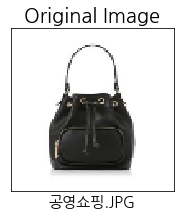

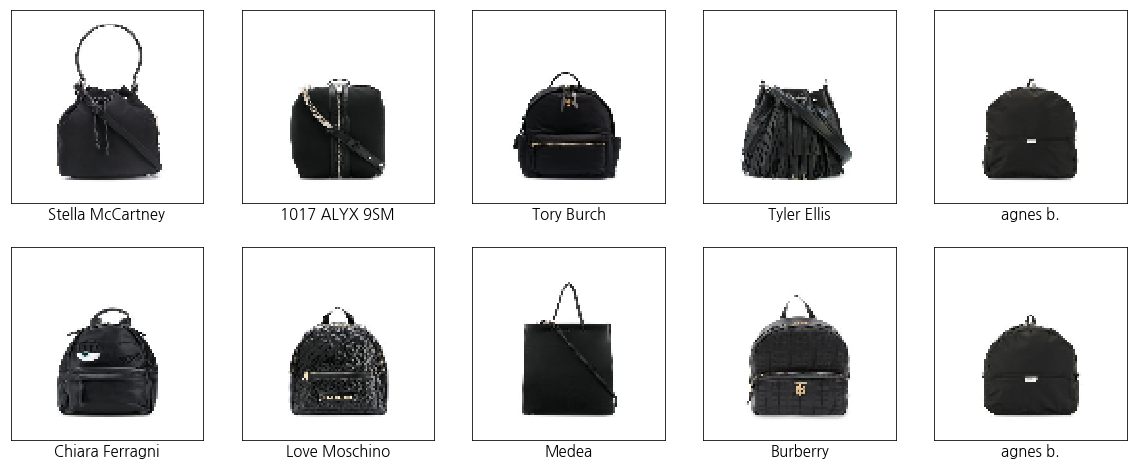

In [96]:
plotImages(input_ind[9])

In [100]:
from numpy import dot
from numpy.linalg import norm
import numpy as np

def cos_sim(A, B):
       return dot(A, B)/(norm(A)*norm(B))

In [103]:
img1 = knn.kneighbors([principalComponents[input_ind[9]]])[1][0][0] ## 공영쇼핑 이미지 인덱스
img2 = knn.kneighbors([principalComponents[input_ind[9]]])[1][0][1] ## 검증하고자 하는 명품 이미지 인덱스
print(img1, img2)

17241 13231


In [102]:
print('cosine similarity:', round(cos_sim(principalComponents[img1], principalComponents[img2]),4))

cosine similarity: 0.9834
